## Install Library

In [ ]:
!pip install pandas
!pip install tensorflow
!pip install keras
!pip install scikit-learn
!pip install spacy
!pip install gensim
!pip install seaborn
!pip install matplotlib
!pip install en_core_web_sm
!pip install tqdm
!pip install nltk
!pip install tldextract

## Import Library

In [373]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from nltk.stem import PorterStemmer
import spacy
import sklearn
import nltk
import seaborn as sns
import requests
import datetime
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import tldextract
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Embedding, Input, Lambda, Dropout, BatchNormalization
from keras.metrics import Precision, Recall, AUC, BinaryAccuracy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import gensim.downloader as api
import en_core_web_sm
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dommy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Mount Drive

In [374]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#PATH = '/content/drive/MyDrive/GSoc-CALEL-Test/QAnon-posts.json'

### From File

In [375]:
PATH = 'QAnon-posts.json'

## Analysis dataset

### Read json

In [376]:
df = pd.read_json(PATH, encoding='utf8')
df = pd.json_normalize(df['posts'], sep="_")
referenced_posts_df = pd.json_normalize(df['referenced_posts'].explode(), sep="_").add_prefix('referenced_posts_')
df = pd.concat([df, referenced_posts_df], axis=1, sort=False)
df = df.drop(columns='referenced_posts')

In [377]:
df.head()

,text,post_metadata_author,post_metadata_source_board,post_metadata_source_site,post_metadata_time,post_metadata_id,images,post_metadata_tripcode,post_metadata_source_link,referenced_posts_reference,referenced_posts_text,referenced_posts_images
0,>>147005381\nHRC extradition already in motion...,Anonymous,/pol,4ch,1.509223e+09,1.0,NaN,NaN,NaN,>>147005381,>>146981635\nHillary Clinton will be arrested ...,NaN
1,"Mockingbird \nHRC detained, not arrested (yet)...",Anonymous,/pol,4ch,1.509229e+09,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Open your eyes.\nIt finally came out that Rod/...,Anonymous,/pol,4ch,1.509292e+09,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,"Some of us come here to drop crumbs, just crum...",Anonymous,/pol,4ch,1.509294e+09,4.0,NaN,NaN,NaN,NaN,NaN,NaN
4,"Follow the money, it’s the key.\nWhat is Pelos...",Anonymous,/pol,4ch,1.509296e+09,5.0,NaN,NaN,NaN,NaN,NaN,NaN


In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   text                        4735 non-null   object 
 1   post_metadata_author        4966 non-null   object 
 2   post_metadata_source_board  4966 non-null   object 
 3   post_metadata_source_site   4966 non-null   object 
 4   post_metadata_time          4966 non-null   float64
 5   post_metadata_id            4966 non-null   float64
 6   images                      1032 non-null   object 
 7   post_metadata_tripcode      4802 non-null   object 
 8   post_metadata_source_link   1396 non-null   object 
 9   referenced_posts_reference  1560 non-null   object 
 10  referenced_posts_text       1506 non-null   object 
 11  referenced_posts_images     585 non-null    object 
dtypes: float64(2), object(10)
memory usage: 469.0+ KB


In [379]:
df = df.dropna(subset=['text', 'referenced_posts_text'], how='all')

I wanted to eliminate the records not having the text because the whole analysis will be based on it

In [380]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4810 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   text                        4735 non-null   object 
 1   post_metadata_author        4805 non-null   object 
 2   post_metadata_source_board  4805 non-null   object 
 3   post_metadata_source_site   4805 non-null   object 
 4   post_metadata_time          4805 non-null   float64
 5   post_metadata_id            4805 non-null   float64
 6   images                      871 non-null    object 
 7   post_metadata_tripcode      4642 non-null   object 
 8   post_metadata_source_link   1311 non-null   object 
 9   referenced_posts_reference  1555 non-null   object 
 10  referenced_posts_text       1506 non-null   object 
 11  referenced_posts_images     580 non-null    object 
dtypes: float64(2), object(10)
memory usage: 488.5+ KB


### Define function & EDA

In [381]:
def ConvertDate(timestamp):
  return datetime.datetime.utcfromtimestamp(timestamp)

def AdjustReference(df):
  df['referenced_posts_reference'] = df['referenced_posts_reference'].str.extract(r'(^.*?(?:>>\d+)?)')
  return df

def ExtractReference(df, input_column, output_column):
  # Extract the reference from the input column and create a new output_column column
  df[output_column] = df[input_column].apply(lambda x: x.split('\n', 1)[0] if isinstance(x, str) and x.startswith('>>') and '\n' in x else None)
  # Remove the reference from the input_column column if present
  df[input_column] = df[input_column].apply(lambda x: x.split('\n', 1)[1] if isinstance(x, str) and x.startswith('>>') and '\n' in x else x)
  return df

def TransformImages(df):
  df['images'] = df['images'].notna().astype(int)
  return df

def AddRefText(df):
  df["ref_text"] = df['referenced_posts_text'].notna().astype(int)
  return df

In [382]:
df['post_metadata_time'] = df['post_metadata_time'].fillna(0).astype(int).apply(ConvertDate)
df = AdjustReference(df)
df = ExtractReference(df, 'text', 'code_text')
df = ExtractReference(df, 'referenced_posts_text', 'code_posts_text')

C:\Users\dommy\AppData\Local\Temp\ipykernel_9584\1347523557.py:2: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.datetime.utcfromtimestamp(timestamp)


In [383]:
df.head()

,text,post_metadata_author,post_metadata_source_board,post_metadata_source_site,post_metadata_time,post_metadata_id,images,post_metadata_tripcode,post_metadata_source_link,referenced_posts_reference,referenced_posts_text,referenced_posts_images,code_text,code_posts_text
0,HRC extradition already in motion effective ye...,Anonymous,/pol,4ch,2017-10-28 20:44:28,1.0,NaN,NaN,NaN,>>147005381,Hillary Clinton will be arrested between 7:45 ...,NaN,>>147005381,>>146981635
1,"Mockingbird \nHRC detained, not arrested (yet)...",Anonymous,/pol,4ch,2017-10-28 22:15:48,2.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None
2,Open your eyes.\nIt finally came out that Rod/...,Anonymous,/pol,4ch,2017-10-29 15:47:07,3.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None
3,"Some of us come here to drop crumbs, just crum...",Anonymous,/pol,4ch,2017-10-29 16:11:40,4.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None
4,"Follow the money, it’s the key.\nWhat is Pelos...",Anonymous,/pol,4ch,2017-10-29 16:47:18,5.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None


### Analysis Each Column

#### Source_site

In [384]:
df["post_metadata_source_site"].value_counts()

post_metadata_source_site
8ch     3266
8kun    1311
4ch      228
Name: count, dtype: int64

As seen on [*wikipedia*](https://en.wikipedia.org/wiki/8chan), 8ch became 8kun after it was shut down, so even though they are the same thing, I can expect the language to change in a more moderate way. <br> The same reasoning is applicable with 4ch. <br>
For more information, this [paper](https://www.jstor.org/stable/26984798) is useful

In [385]:
df[df["post_metadata_source_site"] == "8ch"]["post_metadata_time"].max()

Timestamp('2019-08-01 17:22:36')

In [386]:
df[df["post_metadata_source_site"] == "8kun"]["post_metadata_time"].min()

Timestamp('2019-11-02 19:47:25')

confirmation of dates between 8ch and 8kun

In [387]:
df[df["post_metadata_source_site"] == "4ch"]["post_metadata_time"].max()

Timestamp('2017-12-15 02:52:47')

#### post_metadata_source_board

In [388]:
df["post_metadata_source_board"].value_counts()

post_metadata_source_board
/qresearch         3770
/patriotsfight      396
/pol                243
/cbts               214
/greatawakening     114
/thestorm            41
/projectdcomms       27
Name: count, dtype: int64

In [389]:
df['post_metadata_source_board'] = df['post_metadata_source_board'].str.replace('/', '')

It is a field to be left because depending on the section you may find one topic more gory than another

#### post_metadata_author

In [390]:
df["post_metadata_author"].value_counts()

post_metadata_author
Q                         4414
Q                          228
Anonymous                  159
Anonymous                    2
!ITPb.qbhqo                  1
NowC@mesTHEP@in—-23!!!       1
Name: count, dtype: int64

It is a column I would eliminate due to its poor information content

#### post_metadata_tripcode

In [391]:
df["post_metadata_tripcode"].value_counts()

post_metadata_tripcode
!!mG7VJxZNCI    1766
!!Hs1Jq13jV6    1244
!UW.yye1fxo      572
!CbboFOtcZs      387
!xowAT4Z3VQ      350
!ITPb.qbhqo      211
!4pRcUA0lBE       87
!A6yxsPKia.       16
!2jsTvXXmXs        9
Name: count, dtype: int64

It is a column I would delete because I am not interested in understanding who wrote the post, I want to analyse the language

#### post_metadata_source_link

In [392]:
df["post_metadata_source_link"].value_counts()

post_metadata_source_link
https://8kun.top/qresearch/res/7307489.html#7350508      1
https://8kun.top/qresearch/res/9646127.html#9646819      1
https://8kun.top/qresearch/res/9712063.html#9712328      1
https://8kun.top/qresearch/res/9712063.html#9712258      1
https://8kun.top/qresearch/res/9706652.html#9707125      1
                                                        ..
https://8kun.top/qresearch/res/8981413.html#8981774      1
https://8kun.top/qresearch/res/8981413.html#8981639      1
https://8kun.top/qresearch/res/8981413.html#8981568      1
https://8kun.top/qresearch/res/8980665.html#8981377      1
https://8kun.top/qresearch/res/17830133.html#17830326    1
Name: count, Length: 1311, dtype: int64

this is also a column potentially to be deleted because the relevant information is extracted with the other fields

#### referenced_posts_reference

In [393]:
for index, row in df.iterrows():
    referenced_post = row['referenced_posts_reference']
    code_text = row['code_text']
    code_posts_text = row['code_posts_text']

    if code_posts_text == referenced_post:
        print(f"The value {code_posts_text} in the 'code_posts_text' column is equal to the value {referenced_post} in the 'referenced_posts_reference' column.")

No referenced_posts_text and text will be merged into a single field, the text field

In [394]:
df = AddRefText(df)

In [395]:
df.head()

,text,post_metadata_author,post_metadata_source_board,post_metadata_source_site,post_metadata_time,post_metadata_id,images,post_metadata_tripcode,post_metadata_source_link,referenced_posts_reference,referenced_posts_text,referenced_posts_images,code_text,code_posts_text,ref_text
0,HRC extradition already in motion effective ye...,Anonymous,pol,4ch,2017-10-28 20:44:28,1.0,NaN,NaN,NaN,>>147005381,Hillary Clinton will be arrested between 7:45 ...,NaN,>>147005381,>>146981635,1
1,"Mockingbird \nHRC detained, not arrested (yet)...",Anonymous,pol,4ch,2017-10-28 22:15:48,2.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None,0
2,Open your eyes.\nIt finally came out that Rod/...,Anonymous,pol,4ch,2017-10-29 15:47:07,3.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None,0
3,"Some of us come here to drop crumbs, just crum...",Anonymous,pol,4ch,2017-10-29 16:11:40,4.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None,0
4,"Follow the money, it’s the key.\nWhat is Pelos...",Anonymous,pol,4ch,2017-10-29 16:47:18,5.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None,0


In [396]:
df = df.drop(["code_posts_text", "code_text"], axis=1)

In [397]:
df.head()

,text,post_metadata_author,post_metadata_source_board,post_metadata_source_site,post_metadata_time,post_metadata_id,images,post_metadata_tripcode,post_metadata_source_link,referenced_posts_reference,referenced_posts_text,referenced_posts_images,ref_text
0,HRC extradition already in motion effective ye...,Anonymous,pol,4ch,2017-10-28 20:44:28,1.0,NaN,NaN,NaN,>>147005381,Hillary Clinton will be arrested between 7:45 ...,NaN,1
1,"Mockingbird \nHRC detained, not arrested (yet)...",Anonymous,pol,4ch,2017-10-28 22:15:48,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Open your eyes.\nIt finally came out that Rod/...,Anonymous,pol,4ch,2017-10-29 15:47:07,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0
3,"Some of us come here to drop crumbs, just crum...",Anonymous,pol,4ch,2017-10-29 16:11:40,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0
4,"Follow the money, it’s the key.\nWhat is Pelos...",Anonymous,pol,4ch,2017-10-29 16:47:18,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0


In [398]:
df = df.dropna(subset='text', how='all')

In [399]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4735 entries, 0 to 4965
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   text                        4735 non-null   object        
 1   post_metadata_author        4735 non-null   object        
 2   post_metadata_source_board  4735 non-null   object        
 3   post_metadata_source_site   4735 non-null   object        
 4   post_metadata_time          4735 non-null   datetime64[ns]
 5   post_metadata_id            4735 non-null   float64       
 6   images                      802 non-null    object        
 7   post_metadata_tripcode      4572 non-null   object        
 8   post_metadata_source_link   1294 non-null   object        
 9   referenced_posts_reference  1480 non-null   object        
 10  referenced_posts_text       1431 non-null   object        
 11  referenced_posts_images     547 non-null    object        
 1

#### images

In [400]:
df["images"].value_counts()

images
[{'file': 'f768deaef22da979abcfb73c9175b54d71fcf891666c5449c1969c07c3cc8920.png', 'name': 'f768deaef22da979abcfb73c9175b54d71fcf891666c5449c1969c07c3cc8920.png'}]                                                                                                                                                                                     6
[{'file': 'eaed091c37f3f79bc2142ccffbce93fbcdb59a8def999e4369669ddac0de70fb.jpg', 'name': 'eaed091c37f3f79bc2142ccffbce93fbcdb59a8def999e4369669ddac0de70fb.jpg'}]                                                                                                                                                                                     3
[{'file': '00db16b1e4fc01beb688a4b51cd1d095c5d4d015141ca35007d679435d2a9d7a.jpg', 'name': '00db16b1e4fc01beb688a4b51cd1d095c5d4d015141ca35007d679435d2a9d7a.jpg'}]                                                                                                                                             

not having access to the images this column is useless, however if one had access to the images one could try to do a sentiment analysis on the images using CNNs.
However, the information of having an image associated with the text I do not want to lose.

In [401]:
df = TransformImages(df)

In [402]:
df["images"].value_counts()

images
0    3933
1     802
Name: count, dtype: int64

#### referenced_posts_images

In [403]:
df["referenced_posts_images"].value_counts()

referenced_posts_images
[{'file': '1509515281385.png', 'name': 'Spy.png'}]                                                                                                                                                                                                                                                               1
[{'file': 'e33713d716db53a705938f776e26e428549e583ec324da01fda29f416a47771b.png', 'name': '8chan.png'}]                                                                                                                                                                                                          1
[{'file': 'f3db1ee83116e822e1b5c74066aebcce6ab97d5e806acf23398cc156e2453eb2.jpeg', 'name': '060B9FC5-F4C9-4303-B1ED-1EA5860A572E.jpeg'}]                                                                                                                                                                         1
[{'file': 'eb226a9748f6fafca7a81506ff23e60b0e12f4f0e0cc

same as before

#### Drop useless columns

In [404]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4735 entries, 0 to 4965
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   text                        4735 non-null   object        
 1   post_metadata_author        4735 non-null   object        
 2   post_metadata_source_board  4735 non-null   object        
 3   post_metadata_source_site   4735 non-null   object        
 4   post_metadata_time          4735 non-null   datetime64[ns]
 5   post_metadata_id            4735 non-null   float64       
 6   images                      4735 non-null   int32         
 7   post_metadata_tripcode      4572 non-null   object        
 8   post_metadata_source_link   1294 non-null   object        
 9   referenced_posts_reference  1480 non-null   object        
 10  referenced_posts_text       1431 non-null   object        
 11  referenced_posts_images     547 non-null    object        
 1

In [405]:
df = df.drop(["post_metadata_id", "referenced_posts_images", "post_metadata_source_link", "post_metadata_author", "post_metadata_tripcode", "referenced_posts_reference"], axis=1)

In [406]:
df.head()

,text,post_metadata_source_board,post_metadata_source_site,post_metadata_time,images,referenced_posts_text,ref_text
0,HRC extradition already in motion effective ye...,pol,4ch,2017-10-28 20:44:28,0,Hillary Clinton will be arrested between 7:45 ...,1
1,"Mockingbird \nHRC detained, not arrested (yet)...",pol,4ch,2017-10-28 22:15:48,0,NaN,0
2,Open your eyes.\nIt finally came out that Rod/...,pol,4ch,2017-10-29 15:47:07,0,NaN,0
3,"Some of us come here to drop crumbs, just crum...",pol,4ch,2017-10-29 16:11:40,0,NaN,0
4,"Follow the money, it’s the key.\nWhat is Pelos...",pol,4ch,2017-10-29 16:47:18,0,NaN,0


In [407]:
df.describe(include=[object])

,text,post_metadata_source_board,post_metadata_source_site,referenced_posts_text
count,4735,4735,4735,1431
unique,4640,7,3,1408
top,SEC_TEST\nQ,qresearch,8ch,Worth remembering.\nQ
freq,7,3719,3213,3


### Graph

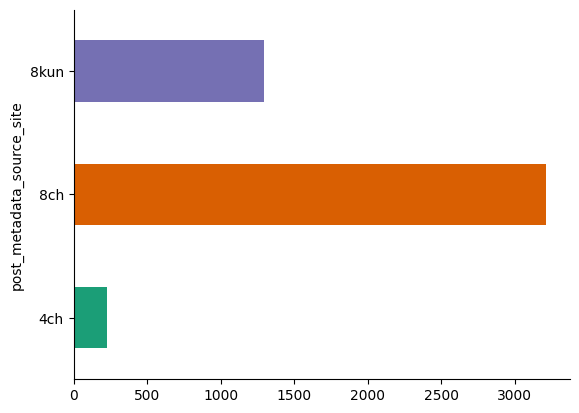

In [408]:
df.groupby('post_metadata_source_site').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

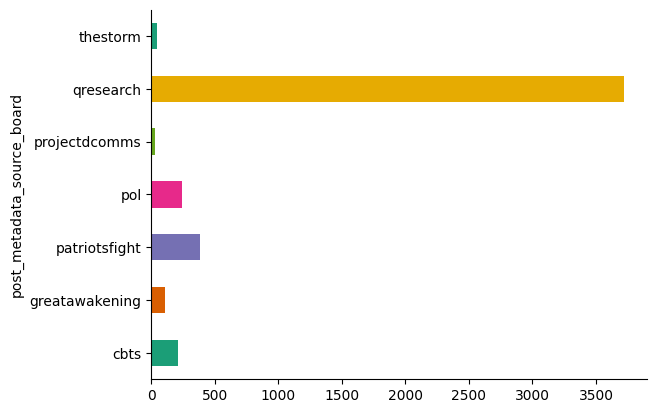

In [409]:
df.groupby('post_metadata_source_board').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

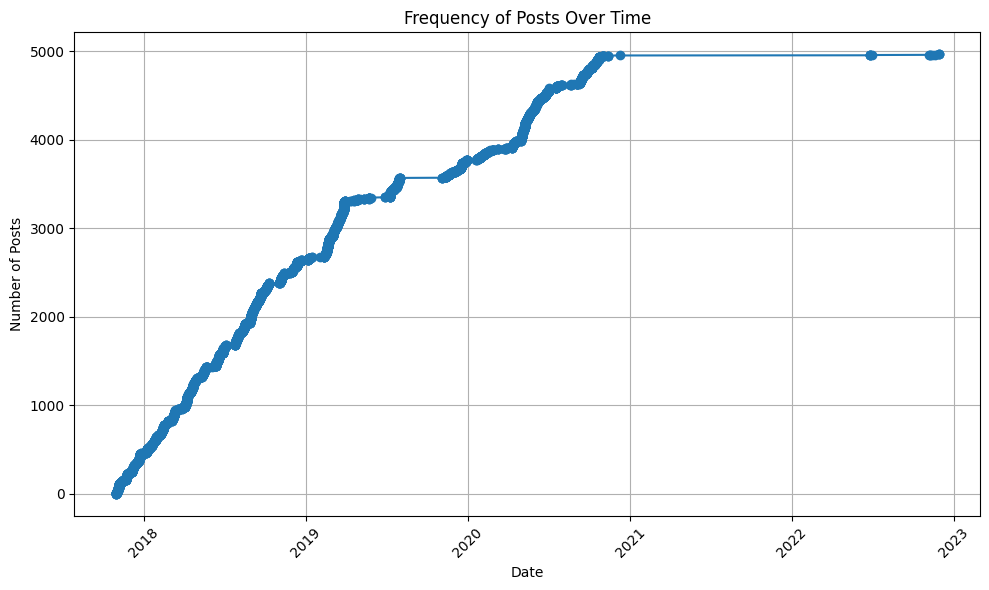

In [410]:
plt.figure(figsize=(10, 6))
plt.plot(df['post_metadata_time'], df.index, marker='o')
plt.title('Frequency of Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

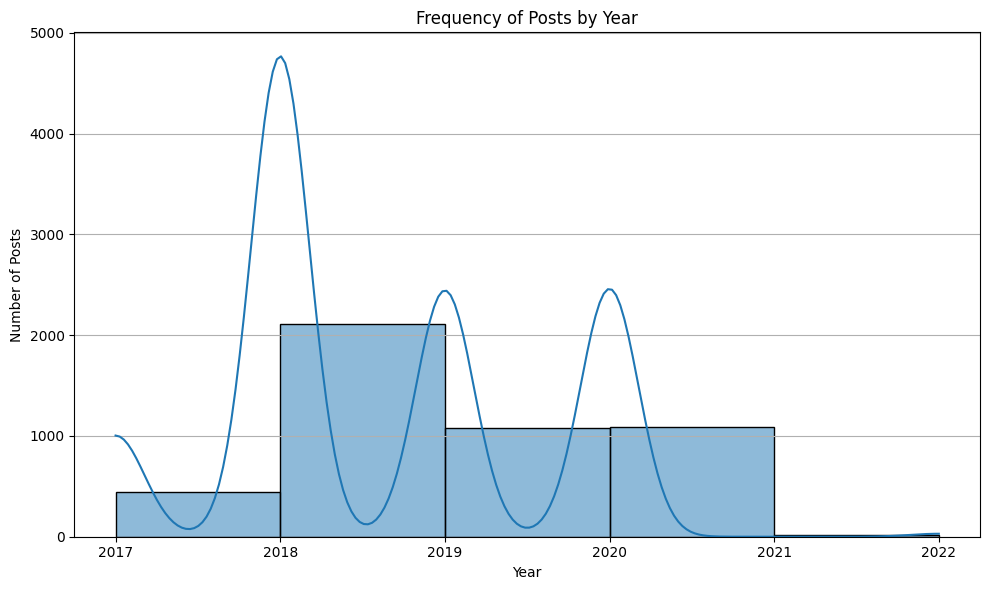

In [411]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=pd.to_datetime(df['post_metadata_time']).dt.year, bins=len(df['post_metadata_time'].dt.year.unique()), kde=True)
plt.title('Frequency of Posts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

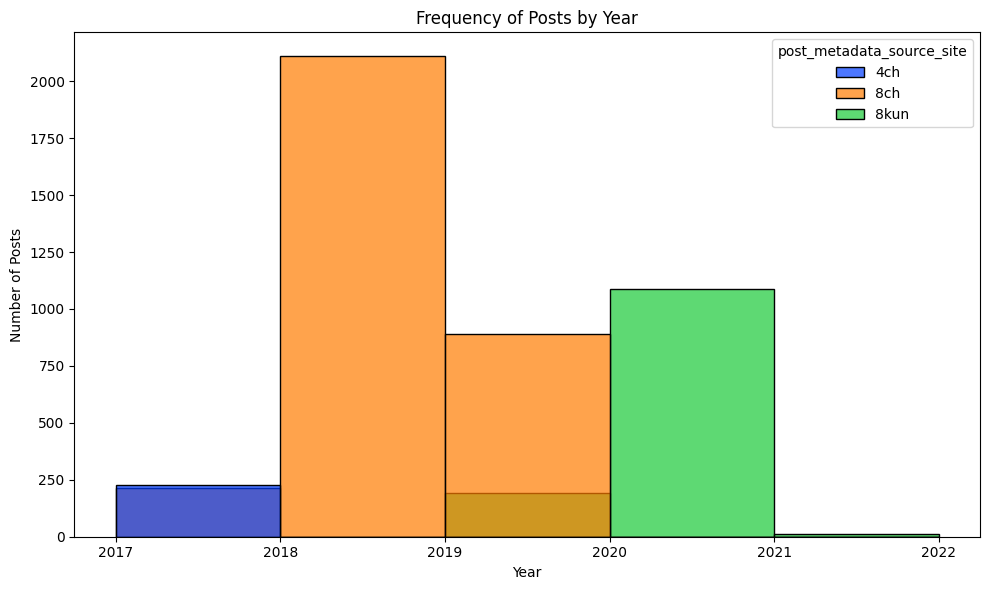

In [412]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=pd.to_datetime(df['post_metadata_time']).dt.year, bins=len(df['post_metadata_time'].dt.year.unique()), hue='post_metadata_source_site', alpha=0.7, palette='bright')
plt.title('Frequency of Posts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.grid(False)
plt.tight_layout()
plt.show()

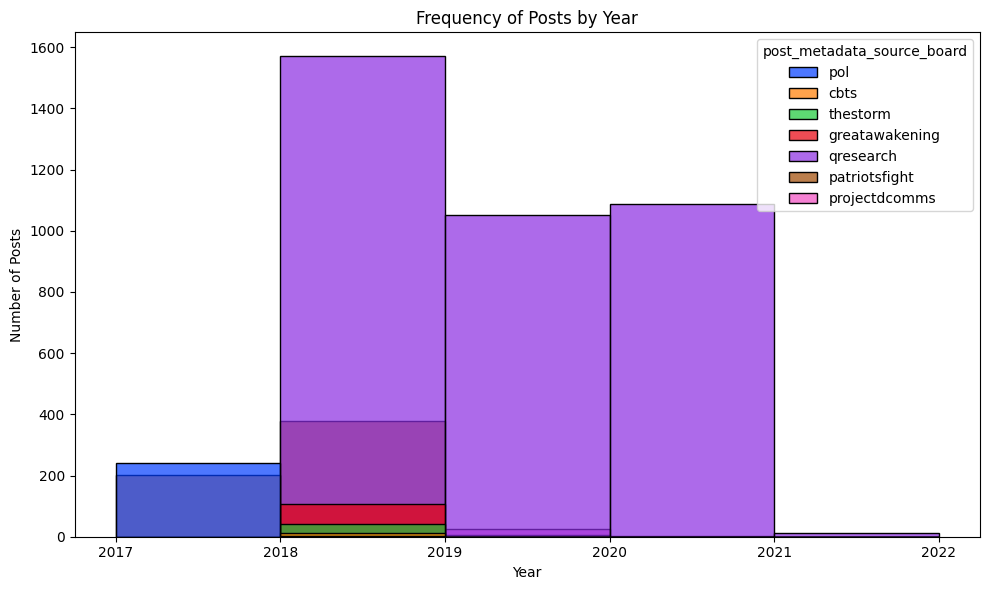

In [413]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=pd.to_datetime(df['post_metadata_time']).dt.year, bins=len(df['post_metadata_time'].dt.year.unique()), hue='post_metadata_source_board', alpha=0.7, palette='bright')
plt.title('Frequency of Posts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.grid(False)
plt.tight_layout()
plt.show()

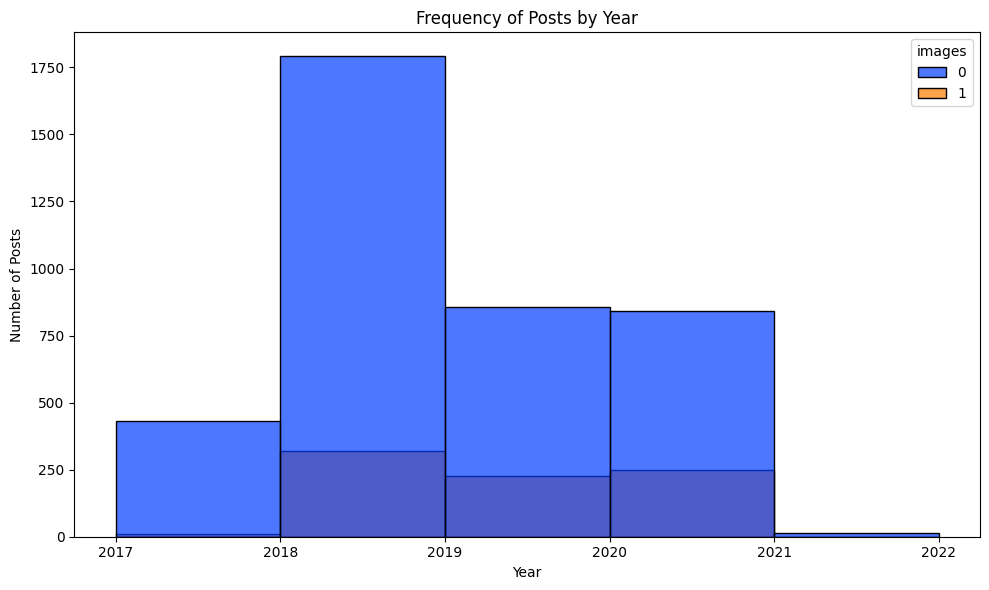

In [414]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=pd.to_datetime(df['post_metadata_time']).dt.year, bins=len(df['post_metadata_time'].dt.year.unique()), hue='images', alpha=0.7, palette='bright')
plt.title('Frequency of Posts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()

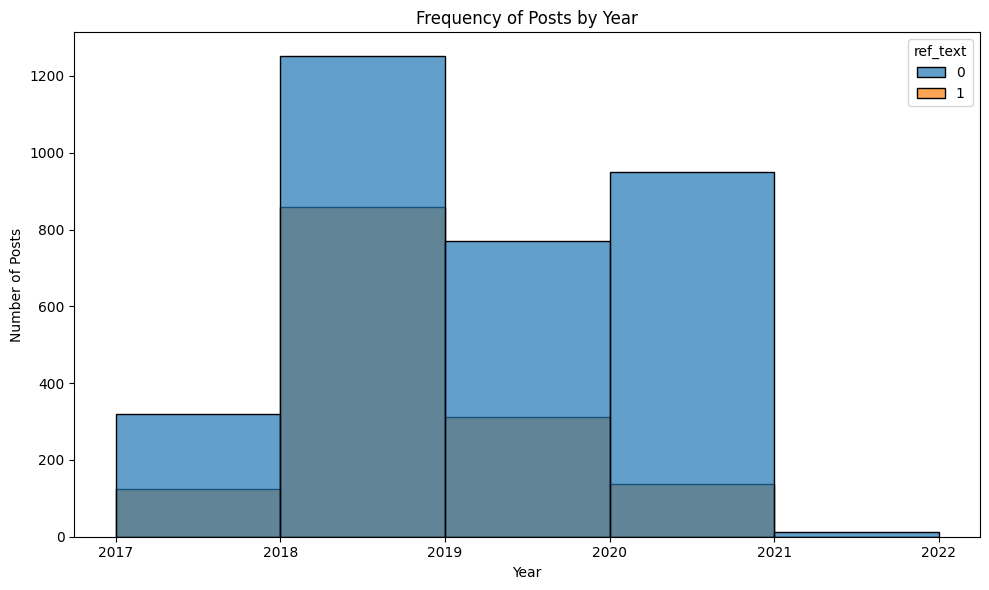

In [415]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=pd.to_datetime(df['post_metadata_time']).dt.year, bins=len(df['post_metadata_time'].dt.year.unique()), hue='ref_text', alpha=0.7, palette='tab10')
plt.title('Frequency of Posts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()

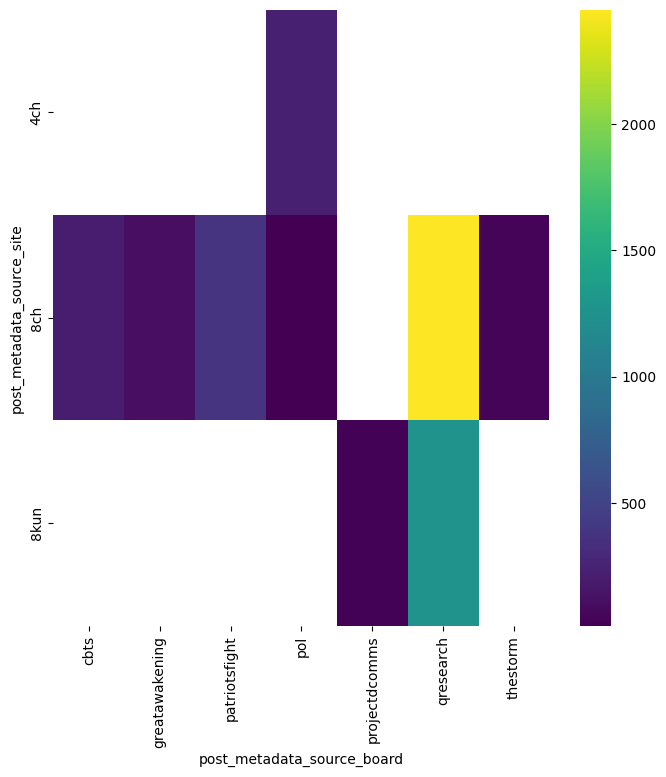

In [416]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['post_metadata_source_site'].value_counts()
    for x_label, grp in df.groupby('post_metadata_source_board')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('post_metadata_source_board')
_ = plt.ylabel('post_metadata_source_site')

## Feature Selection

In [417]:
mapping_ren = {
    'post_metadata_source_site': 'source_site',
    'post_metadata_source_board': 'source_board'
}

df = df.rename(columns=mapping_ren)


### Define functions

In [418]:
def generateDummies(df, feature):

  # Get the dummy variables for the specified feature
  dummies = pd.get_dummies(df[feature], prefix=feature)

  # Add the dummy variables to the original DataFrame
  df = pd.concat([df, dummies], axis=1)

  return df

def appendText(df):

  # Append the content of 'referenced_posts_text' to 'text' where 'referenced_posts_text' is not NaN
  df['text'] = df['text'] + df['referenced_posts_text'].fillna('')

  # Drop the 'referenced_posts_text' column
  df.drop(columns=['referenced_posts_text'], inplace=True)
  return df

def handleDateTime(df):

  df[['year', 'month', 'week', 'day', 'hour', 'minute', 'dayofweek', 'is_weekend']] = \
        df['post_metadata_time'].apply(lambda x: pd.Series([x.year, x.month, x.isocalendar()[1], x.day, x.hour, x.minute, x.dayofweek, 1 if x.dayofweek in [5, 6] else 0]))

  # Add semester column
  df['semester'] = df['month'].apply(lambda x: 1 if x <= 6 else 2)

  # Add quarter column
  df['quarter'] = df['post_metadata_time'].dt.quarter

  df.drop(columns=['post_metadata_time'], inplace=True)

  return df

def handleMonthYear(df):

  features = ['year', 'month', 'quarter']
  for feature in features:
      df = generateDummies(df, feature)
  df.drop(["week", "day", "hour", "minute", "dayofweek", "month", "year", "quarter"], axis=1, inplace=True)

  return df

In [419]:
df = generateDummies(df, "source_board")
df = generateDummies(df, "source_site")
df = appendText(df)
df = handleDateTime(df)

In [420]:
df.head()

,text,source_board,source_site,images,ref_text,source_board_cbts,source_board_greatawakening,source_board_patriotsfight,source_board_pol,source_board_projectdcomms,...,year,month,week,day,hour,minute,dayofweek,is_weekend,semester,quarter
0,HRC extradition already in motion effective ye...,pol,4ch,0,1,False,False,False,True,False,...,2017,10,43,28,20,44,5,1,2,4
1,"Mockingbird \nHRC detained, not arrested (yet)...",pol,4ch,0,0,False,False,False,True,False,...,2017,10,43,28,22,15,5,1,2,4
2,Open your eyes.\nIt finally came out that Rod/...,pol,4ch,0,0,False,False,False,True,False,...,2017,10,43,29,15,47,6,1,2,4
3,"Some of us come here to drop crumbs, just crum...",pol,4ch,0,0,False,False,False,True,False,...,2017,10,43,29,16,11,6,1,2,4
4,"Follow the money, it’s the key.\nWhat is Pelos...",pol,4ch,0,0,False,False,False,True,False,...,2017,10,43,29,16,47,6,1,2,4


## Handle Text

In [421]:
nlp = spacy.load('en_core_web_sm')

In [422]:
def cleanSentences(text):
  # Remove multiple spaces
  processed_text = re.sub(r'\s+', ' ', text)
  # Find URL
  urls = re.findall(r'http[s]?://\S+', processed_text)

  # Extract domains
  for url in urls:
      processed_text = processed_text.replace(url, tldextract.extract(url).domain)

  # Remove punctuation and non-alphanumeric characters
  processed_text = re.sub(r'[^\w\s]', '', processed_text)

  # Remove leading and trailing spaces
  processed_text = processed_text.strip()

  # Remove numbers, letters, and remaining underscores
  processed_text = re.sub(r'\d|\b\w\b|_|-', '', processed_text)

  return processed_text

def syntaxAnalysis(column):
    stemmer = PorterStemmer()
    # POS Tagging + Tokenization + Lemmatize + Remove Stop words + Stemming
    processed_texts = []
    for text in tqdm(column, desc="Processing texts", unit="text"):
        tokens = [token.lemma_ for token in nlp(text) if not token.is_stop and token.text.strip() != ""]
        stemmed_tokens = [stemmer.stem(token) for token in tokens]
        processed_texts.append(stemmed_tokens)
    return processed_texts

In [423]:
df['text'] = df['text'].apply(cleanSentences)

In [424]:
df.head()

,text,source_board,source_site,images,ref_text,source_board_cbts,source_board_greatawakening,source_board_patriotsfight,source_board_pol,source_board_projectdcomms,...,year,month,week,day,hour,minute,dayofweek,is_weekend,semester,quarter
0,HRC extradition already in motion effective ye...,pol,4ch,0,1,False,False,False,True,False,...,2017,10,43,28,20,44,5,1,2,4
1,Mockingbird HRC detained not arrested yet Wher...,pol,4ch,0,0,False,False,False,True,False,...,2017,10,43,28,22,15,5,1,2,4
2,Open your eyes It finally came out that RodBob...,pol,4ch,0,0,False,False,False,True,False,...,2017,10,43,29,15,47,6,1,2,4
3,Some of us come here to drop crumbs just crumb...,pol,4ch,0,0,False,False,False,True,False,...,2017,10,43,29,16,11,6,1,2,4
4,Follow the money its the key What is Pelosis n...,pol,4ch,0,0,False,False,False,True,False,...,2017,10,43,29,16,47,6,1,2,4


In [425]:
df['preprocessed_text'] = syntaxAnalysis(df['text'])

Processing texts:   0%|          | 1/4735 [00:00<09:02,  8.73text/s]

Processing texts: 100%|██████████| 4735/4735 [01:07<00:00, 69.89text/s] 


In [426]:
df.head()

,text,source_board,source_site,images,ref_text,source_board_cbts,source_board_greatawakening,source_board_patriotsfight,source_board_pol,source_board_projectdcomms,...,month,week,day,hour,minute,dayofweek,is_weekend,semester,quarter,preprocessed_text
0,HRC extradition already in motion effective ye...,pol,4ch,0,1,False,False,False,True,False,...,10,43,28,20,44,5,1,2,4,"[hrc, extradit, motion, effect, yesterday, cou..."
1,Mockingbird HRC detained not arrested yet Wher...,pol,4ch,0,0,False,False,False,True,False,...,10,43,28,22,15,5,1,2,4,"[mockingbird, hrc, detain, arrest, huma, follo..."
2,Open your eyes It finally came out that RodBob...,pol,4ch,0,0,False,False,False,True,False,...,10,43,29,15,47,6,1,2,4,"[open, eye, final, come, rodbob, key, player, ..."
3,Some of us come here to drop crumbs just crumb...,pol,4ch,0,0,False,False,False,True,False,...,10,43,29,16,11,6,1,2,4,"[come, drop, crumb, crumb, potu, insul, discus..."
4,Follow the money its the key What is Pelosis n...,pol,4ch,0,0,False,False,False,True,False,...,10,43,29,16,47,6,1,2,4,"[follow, money, key, pelosi, net, worth, way, ..."


## Modeling

**An approach of text cleaning and lexical analysis of the text was considered.
A solution is then proposed using either word embedding or tf-idf with LDA.
Subsequently, the topics and the most relevant words extracted are exploited to label the records in the dataset.
The latter will then be used with supervised learning algorithms such as SVM using a Word Embedding**

### LDA

In [428]:
# Configure parameters for LDA model
preprocessed_text = df['preprocessed_text']
dictionary = Dictionary(preprocessed_text)
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_text]
num_topics = 5
passes = 15
iterations = 100

In [429]:
def choiceMethod(string, vector_size=100):

  if string == "tf-idf":

    tfidf_model = TfidfModel(corpus)
    return tfidf_model[corpus]

  elif string == "word2vec":

    # Train Word2Vec model
    word2vec_model = Word2Vec(sentences=preprocessed_text, vector_size=vector_size, window=10, min_count=2, workers=10)

    # Filter out words not present in the Word2Vec model's vocabulary
    preprocessed_texts_filtered = [[word for word in doc if word in word2vec_model.wv] for doc in preprocessed_text]

    # Convert the filtered preprocessed texts into bag-of-words representation
    return [dictionary.doc2bow(doc) for doc in preprocessed_texts_filtered]

def printTopTopic(lda_model, num_topics=3, num_words=10):
  top_topics = lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)

  for i, (topic_id, topic) in enumerate(top_topics):
      print(f"Topic {topic_id + 1}:")
      print("Keyword:", [word for word, _ in topic])

#### 1° Attempt

In [430]:
corpus = choiceMethod("word2vec")
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, iterations=iterations)
printTopTopic(lda_model, 5, 20)

Topic 1:
Keyword: ['biden', 'youtub', 'china', 'covid', 'bank', 'c', 'death', 'cia', 'central', 'lockdown', 'state', 'blm', 'boom', 'donat', 'foxnew', 'nurs', 'home', 'push', 'nation', 'hussein']
Topic 2:
Keyword: ['twitter', 'child', 'wwgwga', 'god', 'democrat', 'stand', 'republican', 'patriot', 'time', 'year', 'peopl', 'unit', 'fight', 'faith', 'girl', 'evil', 'readi', 'countri', 'state', 'sex']
Topic 3:
Keyword: ['think', 'know', 'coincid', 'comey', 'twitter', 'potu', 'jame', 'fbi', 'post', 'come', 'investig', 'drop', 'treason', 'public', 'not', 'fire', 'time', 'archiv', 'anon', 'news']
Topic 4:
Keyword: ['govern', 'brennan', 'john', 'treason', 'insurg', 'right', 'polit', 'long', 'organ', 'control', 'secur', 'form', 'support', 'safe', 'forc', 'new', 'peopl', 'power', 'popul', 'activ']
Topic 5:
Keyword: ['control', 'peopl', 'potu', 'elect', 'attack', 'narr', 'think', 'happen', 'parti', 'power', 'state', 'medium', 'push', 'public', 'news', 'prevent', 'polit', 'fake', 'inform', 'divid'

In [431]:
lda_model.print_topics()

[(0,
  '0.014*"biden" + 0.014*"youtub" + 0.014*"china" + 0.010*"covid" + 0.010*"bank" + 0.010*"c" + 0.010*"death" + 0.009*"cia" + 0.007*"central" + 0.007*"lockdown"'),
 (1,
  '0.083*"twitter" + 0.016*"child" + 0.015*"wwgwga" + 0.015*"god" + 0.012*"democrat" + 0.012*"stand" + 0.011*"republican" + 0.010*"patriot" + 0.010*"time" + 0.008*"year"'),
 (2,
  '0.015*"think" + 0.010*"know" + 0.009*"coincid" + 0.008*"comey" + 0.008*"twitter" + 0.007*"potu" + 0.007*"jame" + 0.007*"fbi" + 0.006*"post" + 0.006*"come"'),
 (3,
  '0.017*"govern" + 0.016*"brennan" + 0.016*"john" + 0.015*"treason" + 0.012*"insurg" + 0.011*"right" + 0.008*"polit" + 0.007*"long" + 0.006*"organ" + 0.006*"control"'),
 (4,
  '0.016*"control" + 0.012*"peopl" + 0.008*"potu" + 0.007*"elect" + 0.007*"attack" + 0.007*"narr" + 0.006*"think" + 0.006*"happen" + 0.006*"parti" + 0.006*"power"')]

#### 2° Attempt

In [432]:
corpus = choiceMethod("tf-idf")
lda_model2 = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=20, update_every=2, iterations=150, minimum_probability=0.001)
printTopTopic(lda_model2, 5, 20)

Topic 1:
Keyword: ['twitter', 'control', 'happen', 'think', 'peopl', 'elect', 'time', 'potu', 'breitbart', 'attack', 'know', 'news', 'come', 'viru', 'push', 'public', 'fake', 'day', 'parti', 'state']
Topic 2:
Keyword: ['twitter', 'wwgwga', 'god', 'faith', 'truth', 'stand', 'human', 'peopl', 'warfar', 'inform', 'patriot', 'know', 'long', 'chang', 'bless', 'light', 'let', 'difficult', 'find', 'deep']
Topic 3:
Keyword: ['insurg', 'test', 'signal', 'escap', 'fun', 'troll', 'organ', 'treason', 'newsbreak', 'hell', 'congress', 'expect', 'qpain', 'suffici', 'church', 'qlet', 'saraacart', 'def', 'what', 'subvers']
Topic 4:
Keyword: ['youtub', 'worth', 'rememb', 'twitter', 'buckl', 'militari', 'rider', 'pb', 'pattern', 'readi', 'midnight', 'welcom', 'foxnew', 'parti', 'con', 'pen', 'follow', 'nypost', 'game', 'meme']
Topic 5:
Keyword: ['foxnew', 'coincid', 'reconcil', 'believ', 'dan', 'updat', 'unleash', 'correct', 'bing', 'pg', 'brennan', 'john', 'endless', 'senat', 'perfectli', 'august', 'lis

In [433]:
lda_model2.print_topics()

[(0,
  '0.006*"twitter" + 0.005*"control" + 0.004*"happen" + 0.004*"think" + 0.004*"peopl" + 0.003*"elect" + 0.003*"time" + 0.003*"potu" + 0.003*"breitbart" + 0.003*"attack"'),
 (1,
  '0.060*"twitter" + 0.030*"wwgwga" + 0.006*"god" + 0.006*"faith" + 0.005*"truth" + 0.005*"stand" + 0.005*"human" + 0.005*"peopl" + 0.005*"warfar" + 0.005*"inform"'),
 (2,
  '0.005*"insurg" + 0.003*"test" + 0.003*"signal" + 0.002*"escap" + 0.002*"fun" + 0.002*"troll" + 0.002*"organ" + 0.002*"treason" + 0.002*"newsbreak" + 0.002*"hell"'),
 (3,
  '0.028*"youtub" + 0.008*"worth" + 0.007*"rememb" + 0.006*"twitter" + 0.005*"buckl" + 0.005*"militari" + 0.005*"rider" + 0.004*"pb" + 0.004*"pattern" + 0.004*"readi"'),
 (4,
  '0.016*"foxnew" + 0.005*"coincid" + 0.004*"reconcil" + 0.003*"believ" + 0.003*"dan" + 0.002*"updat" + 0.002*"unleash" + 0.002*"correct" + 0.002*"bing" + 0.002*"pg"')]

### Assign label: top 20 words for top 5 topics

In [434]:
df["label"] = -1

In [435]:
top_topics = lda_model2.show_topics(num_topics=5, num_words=10, formatted=False)

for index, row in df.iterrows():
    preprocessed_text_tokens = set(row['preprocessed_text'])

    matching_topics = []

    # Scan topics to find matches with words in preprocessed_text
    for topic_id, topic_words in top_topics:
        top_words = [word for word, _ in topic_words]

        # Count the number of words in preprocessed_text that belong to the topic
        matching_words_count = sum(1 for word in preprocessed_text_tokens if word in top_words)

        # If at least one word belongs to the topic, add the topic to the list of matches
        if matching_words_count >= 1:
            matching_topics.append(topic_id)

    # Assign the label of the first topic in the list of matches, if present
    if matching_topics:
        df.at[index, 'label'] = matching_topics[0] # Assign the label of the topic to the record

In [436]:
df["label"].value_counts()

label
 0    2380
-1    1605
 4     232
 1     221
 3     203
 2      94
Name: count, dtype: int64

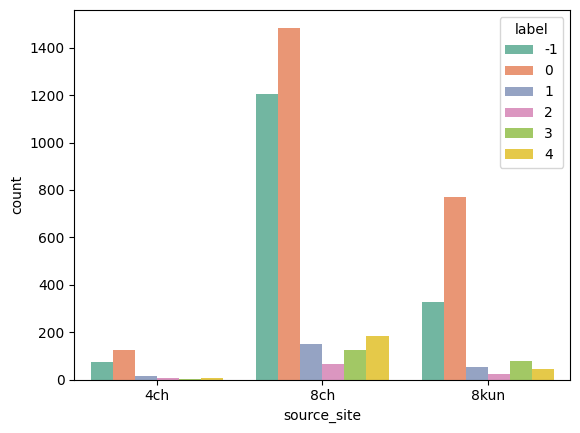

In [437]:
sns.countplot(data=df, x='source_site', hue='label', palette='Set2');

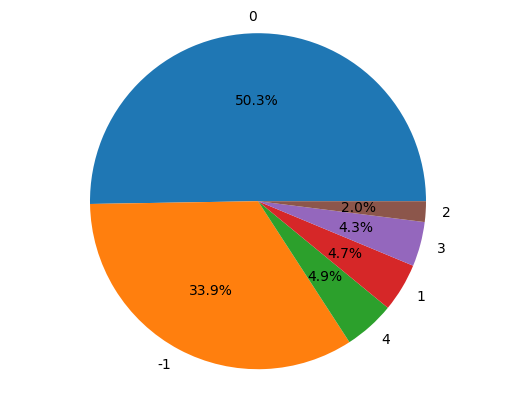

In [438]:
count_source = df["label"].value_counts()
plt.pie(count_source, labels=count_source.index, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

### Word Embedding

In [439]:
glove_model = api.load("glove-twitter-200")

In [440]:
preprocessed_texts = df['preprocessed_text']

# Compute the vector representation for each text
text_embeddings = []

for text in preprocessed_texts:
    word_vectors = [glove_model[token] for token in text if token in glove_model]
    if word_vectors:
        text_vector = np.mean(word_vectors, axis=0)
    else:
        text_vector = None
    text_embeddings.append(text_vector)

# Add the text vector representation to the DataFrame
df['text_embedding'] = text_embeddings

In [441]:
df['text_embedding']

0       [0.09018675, 0.046382446, -0.10595848, -0.0393...
1       [0.04164467, 0.14701524, -0.01595027, 0.093086...
2       [0.013956433, 0.092726655, -0.13473243, 0.0713...
3       [0.041521583, 0.06454467, 0.011430303, -0.0054...
4       [-0.0664136, 0.04639774, -0.018127203, 0.03702...
                              ...                        
4961    [-0.025275335, 0.18886562, 0.0639345, 0.051061...
4962    [-0.13314904, 0.0953594, -0.074461706, 0.11673...
4963    [-0.22390261, 0.19324213, 0.20654124, 0.197322...
4964    [0.25771, -0.096751, 0.32478, -0.42939, 0.1709...
4965    [0.06124311, 0.2283713, -0.10609033, 0.1936692...
Name: text_embedding, Length: 4735, dtype: object

### Classification Model

#### Clean useless columns

In [442]:
df.drop(["text", "source_board", "source_site", "preprocessed_text"], axis=1, inplace=True)

In [443]:
dd = df.copy()

In [444]:
dd = handleMonthYear(dd)

In [445]:
dd.head()

,images,ref_text,source_board_cbts,source_board_greatawakening,source_board_patriotsfight,source_board_pol,source_board_projectdcomms,source_board_qresearch,source_board_thestorm,source_site_4ch,...,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
0,0,1,False,False,False,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
1,0,0,False,False,False,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,0,0,False,False,False,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
3,0,0,False,False,False,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
4,0,0,False,False,False,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True


#### ML Models

In [446]:
df = df[~df['text_embedding'].isnull()]
embedding = np.vstack(df['text_embedding'].tolist())

In [447]:
X = np.concatenate((df.drop(["label", "text_embedding"], axis=1), embedding), axis=1)
y = df["label"]

In [448]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### SVC

In [449]:
param_grid = {'base_estimator__C': [0.1, 1]}

**for reasons of time the grid search was skipped**

In [450]:
svm_classifier = SVC(kernel='linear', probability=True)
# Initialize CalibratedClassifierCV to calibrate probabilities
calibrated_svm = CalibratedClassifierCV(estimator=svm_classifier, method='sigmoid')
# Initialize GridSearchCV
#grid_search = GridSearchCV(estimator=calibrated_svm, param_grid=param_grid, cv=5, scoring='f1')
# Fit GridSearchCV
calibrated_svm = calibrated_svm.fit(X_train, y_train)

#### Predict and Evaluate

In [451]:
# Calculate AUC
y_pred_proba = calibrated_svm.predict_proba(X_test)

In [452]:
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("AUC:", auc)

AUC: 0.854046323622648


In [453]:
y_pred = calibrated_svm.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          -1       0.73      0.64      0.68       298
           0       0.72      0.90      0.80       450
           1       0.74      0.31      0.44        45
           2       0.62      0.24      0.34        21
           3       0.81      0.58      0.68        38
           4       0.92      0.29      0.44        41

    accuracy                           0.73       893
   macro avg       0.76      0.49      0.56       893
weighted avg       0.73      0.73      0.71       893



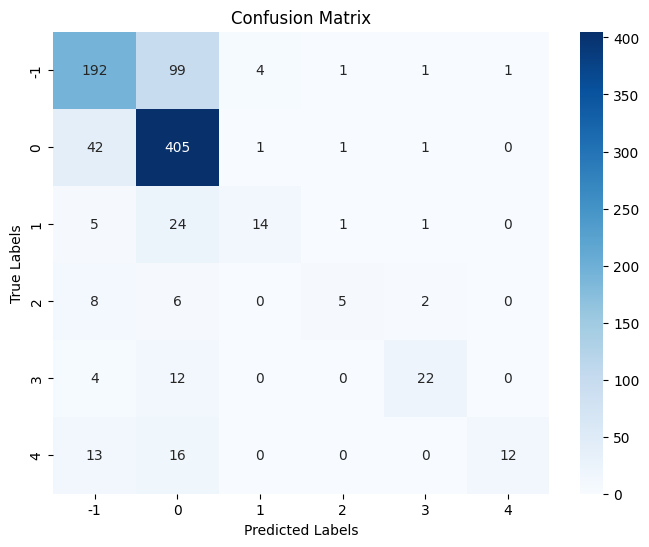

In [454]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=calibrated_svm.classes_, yticklabels=calibrated_svm.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Random Forest with Grid Search

In [455]:
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [10, 20]
}

In [456]:
rf = RandomForestClassifier()
ovr_rf = OneVsRestClassifier(rf)
grid_search = GridSearchCV(estimator=ovr_rf, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)

In [457]:
# Fit CalibratedClassifierCV
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\dommy\miniconda3\envs\gestione\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


In [458]:
# Predict probabilities on test set
y_pred_proba = best_model.predict_proba(X_test)

# Calculate AUC
auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("AUC:", auc_score)

AUC: 0.8381509783633169


In [459]:
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          -1       0.75      0.67      0.70       298
           0       0.72      0.95      0.82       450
           1       0.92      0.24      0.39        45
           2       1.00      0.10      0.17        21
           3       1.00      0.39      0.57        38
           4       1.00      0.17      0.29        41

    accuracy                           0.74       893
   macro avg       0.90      0.42      0.49       893
weighted avg       0.77      0.74      0.71       893



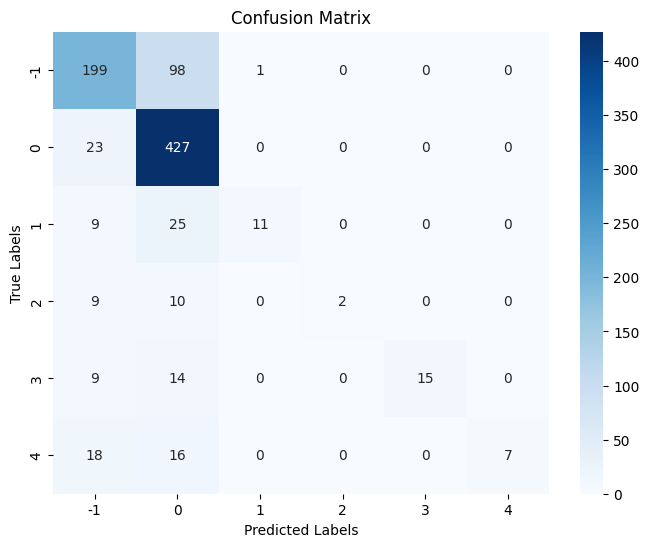

In [460]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### LSTM

In [461]:
y2 = y.replace(-1, 5)

In [462]:
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2, random_state=42)

In [463]:
X_train2 = np.asarray(X_train).astype(np.float32)
X_train2 = np.expand_dims(X_train2, axis=2)
y_train2 = np.asarray(y_train).astype(np.int32)

# Class number
num_classes = 6

In [464]:
# architecture
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train2.shape[1], 1)))
model.add(Dropout(0.2))
#model.add(BatchNormalization())
#model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.add(Dense(64, activation='relu'))
model.add(LSTM(units=1, activation='sigmoid'))
opt = optimizers.Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[AUC(), 'accuracy'])

c:\Users\dommy\miniconda3\envs\gestione\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [465]:
model.summary()

Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_145 (LSTM)                 │ (None, 222, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 222, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 222, 6)         │           774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 222, 64)        │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_146 (LSTM)                 │ (None, 1)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,046 (265.80 KB)

 Trainable params: 68,046 (265.80 KB)

 Non-trainable params: 0 (0.00 B)

In [466]:
# Fit Model
early_stopping_callback = EarlyStopping(monitor='accuracy', patience=3)
model.fit(X_train2, y_train, epochs=50, batch_size=512, callbacks=[early_stopping_callback])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.5452 - auc_52: 0.5018 - loss: 1.7232
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5402 - auc_52: 0.5030 - loss: 1.5960
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5410 - auc_52: 0.4981 - loss: 1.3561
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5309 - auc_52: 0.4821 - loss: 1.1944
